# Imports

In [59]:
!pip install seaborn
!pip install scikit-learn

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, classification_report
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor, GradientBoostingClassifier
from sklearn.preprocessing import OrdinalEncoder, Binarizer

# set style
sns.set(style='whitegrid', palette='pastel')
pd.set_option('display.max_colwidth', None)

In [ ]:
# importing and assigning simplified names
try:
    final_df = pd.read_csv('data/03_primary/olist_final.csv')
except FileNotFoundError:
    print("Try to change the file directories/names")

# Final DF Inspection
inspecting the data to ensure correct import

In [62]:
print(final_df.shape, '\n--------------------')
print(final_df.head().to_string())

(91013, 35) 
--------------------
                 customer_unique_id weekday_<lambda>  hour_median  price_sum  price_mean  freight_value_mean payment_type_<lambda>  payment_installments_mean  payment_value_sum  payment_value_mean  review_score_mean  product_photos_qty_mean  product_weight_g_mean  product_length_cm_mean  product_height_cm_mean  product_width_cm_mean customer_city_<lambda> customer_state_<lambda>  geolocation_lat_mean  geolocation_lng_mean season_<lambda>  delivery_time_mean product_category_name_english  order_count  repeat_buyer  distinct_product_categories  months_inactive  avg_distance_km  volume_mean  cost_volume  density_mean  cost_weight  lh_ratio  lw_ratio  hw_ratio
0  0000366f3b9a7992bf8c76cfdf3221e2         Thursday         10.0     129.90      129.90               12.00           credit_card                        8.0             141.90              141.90                5.0                      1.0                 1500.0                    34.0              

# Eval and Data Functions for Models

In [63]:
def data_splitter(features, target, stratify=True, num_process=StandardScaler(), cat_process=OneHotEncoder(handle_unknown='ignore')):
    """ Splits data for seperate models
    
    Args:
        features: selected features
        target: target to predict
        stratify: classifier=True, regressor=False | balance classes for classifier
        num_process: processing type for num cols
        cat_process: processing type for cat cols
    Returns:
        split data: X_train, X_test, y_train, y_test
    """
    # Separate features and target
    X = final_df[features]
    y = final_df[target]

    # Detect categorical columns (object type)
    categorical_cols = X.select_dtypes(include='object').columns.tolist()
    numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

    # Preprocessing pipeline
    preprocessor = ColumnTransformer([
        ('num', num_process, numeric_cols),
        ('cat', cat_process, categorical_cols)
    ])

    # Transform the data
    X_processed = preprocessor.fit_transform(X)
    
    if stratify:
        X_train, X_test, y_train, y_test = train_test_split(X_processed, y, stratify=y, test_size=0.2, random_state=42)
    else:
        X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

    return X_train, X_test, y_train, y_test

In [64]:
def class_eval(model):
    """ Creates combined train and test metrics + confusion matrix plots directly after model training
    
    Args:
        model: trained classifier model
    Returns:
        printed metrics + confusion matrix plot
    """    
    plt.figure(figsize=(12, 6))
    
    data_list = [[X_test, y_test, "Test"], [X_train, y_train, "Train"]]
    for i, data in enumerate(data_list):
        # data evaluations
        pred_classes = model.predict(data[0])
        true_classes = data[1]

        # init confusion matrix
        cm = confusion_matrix(true_classes, pred_classes)
        tn, fp, fn, tp = confusion_matrix(true_classes, pred_classes).ravel()

        # display results
        print("\n", data[2], "\n------------------------")
        print(f"Accuracy: {accuracy_score(true_classes, pred_classes):.4f}")
        print(f"Precision: {precision_score(true_classes, pred_classes, average='weighted'):.4f}")
        print(f"Recall: {recall_score(true_classes, pred_classes, average='weighted'):.4f}")
        print(f"F1 Score: {f1_score(true_classes, pred_classes, average='weighted'):.4f}")
        print(f"Specificity: {tn/(tn+fp):.4f}")

        plt.subplot(1, 2, i+1)
        sns.heatmap(cm, annot=True, fmt='d', cmap='rocket_r',
                    xticklabels=np.unique(true_classes),
                    yticklabels=np.unique(true_classes))
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title(data[2] + ' Confusion Matrix')

    plt.show()

In [65]:
def rocauc_eval(model):
    """ Display model performance as Receiver Operating Characteristics and Area Under Curve directly after model training
    
    Args:
        model: trained classifier model
        X: X data (training or testing)
        y: y data (training or testing)
        title: title for identification
    Returns:
        ROC AUC plot
    """
    plt.figure(figsize=(12, 6))
    lw = 2
    roc_colours = ['red', 'blue']
    roc_labels = ['Repeat', 'Non-Repeat']

    rocauc_lists = [[model.predict_proba(X_test), y_test, "Test"], [model.predict_proba(X_train), y_train, "Train"]]

    for i, list in enumerate(rocauc_lists):
        plt.subplot(1, 2, i + 1)
        for j in range(2):
            scores = list[0][:, j]
            fpr, tpr, _ = roc_curve(list[1] == j, scores)
            roc_auc = auc(fpr, tpr)

            # plot seperate roc auc
            plt.plot(fpr, tpr, color=roc_colours[j], lw=lw, label=f'{roc_labels[j]}(area = {roc_auc:.2f})')

        # plot grey reference lines
        plt.plot([0, 1], [0, 1], color='gray', lw=lw, linestyle='--')
        plt.plot([0, 1], [1, 1], color='gray', lw=lw, linestyle='--')

        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(list[2] + ' Receiver Operating Characteristics: One-vs-Rest')
        plt.legend(loc="lower right")
    plt.show()

In [66]:
def gridcv_tree(param_grid):
  """ Uses GridSearchCV to find optimal parameters for classifier
    
    Args:
        param_grid: parameter dictionary to optimize
    Returns:
        best estimator + print best parameters
  """
  grid_tree = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid=param_grid, scoring='accuracy', n_jobs=-1)
  grid_tree.fit(X_train, y_train)

  print('Best parameters is:', grid_tree.best_params_)
  print('Parameters: ', grid_tree.best_estimator_.get_params())
  class_eval(grid_tree)
  rocauc_eval(grid_tree)

  return grid_tree.best_estimator_

In [67]:
def cont_eval(model, x_size, y_size):
    """ Evaluates regressors on multiple metrics
    
    Args:
        model: trained regressor model
        x_size: max target value (for graph sizing)
        y_size: max target value (for graph sizing)
    Returns:
        prints metrics + predicted vs true target plot
    """
    cont_list = [[X_test, y_test, "Test"], [X_train, y_train, "Train"]]
    plt.figure(figsize=(12, 6))
    sns.set_palette('hls')

    for i, data in enumerate(cont_list):
        y_pred = model.predict(data[0])

        print("\n", data[2], "\n---------------------------")
        print(f"MAE: {mean_absolute_error(data[1], y_pred) * -1:.4f}")
        print(f"MSE: {mean_squared_error(data[1], y_pred) * -1:.4f}")
        print(f"R^2: {r2_score(data[1], y_pred):.4f}")

        plt.subplot(1, 2, i + 1)
        plt.scatter(y_pred, data[1], alpha=0.2)
        plt.plot([0, x_size], [0, y_size], color="cornflowerblue", lw=2)
        plt.xlabel('Predicted Value')
        plt.ylabel('True Value')
        plt.title(data[2] + " Data Regression Evaluation")
        plt.xlim(0, x_size)
        plt.ylim(0, y_size)
    plt.show()

In [68]:
def randomcv_tree(model, param_dist):
  """ Uses RandomizedSearchCV to find optimal parameters for models
    
    Args:
        model: base model to train
        param_dist: parameter dictionary to optimize
    Returns:
        best estimator + randomized search object
  """
  random_tree = RandomizedSearchCV(
    model,
    param_distributions=param_dist,
    n_iter=25,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    cv=3,
    verbose=2,
    random_state=42
  )
  random_tree.fit(X_train, y_train)

  return random_tree.best_estimator_, random_tree

In [69]:
def feature_imp(model, features):
    """ Plot feature importance from model
    
    Args:
        model: trained model
        features: selected features for the graph
    Returns:
        sorted feature importance plot
    """
    # Assuming X_processed is a DataFrame
    importances = model.feature_importances_

    # filter and sort features
    filtered_indices = [i for i, name in enumerate(features)]
    filtered_names = [features[i] for i in filtered_indices]
    filtered_importances = [importances[i] for i in filtered_indices]

    sorted_idx = np.argsort(filtered_importances)[::-1]
    sorted_names = [filtered_names[i] for i in sorted_idx]
    sorted_importances = [filtered_importances[i] for i in sorted_idx]

    plt.bar(range(len(sorted_importances)), sorted_importances)
    plt.title("Feature Importances")
    plt.xticks(range(len(sorted_importances)), sorted_names, rotation=90)
    plt.xlabel("Features")
    plt.ylabel("Importance")
    plt.tight_layout()
    plt.show()

# ML Model for Repeat Buyers

In [70]:
print(final_df.head().to_string())
print(final_df.columns)

                 customer_unique_id weekday_<lambda>  hour_median  price_sum  price_mean  freight_value_mean payment_type_<lambda>  payment_installments_mean  payment_value_sum  payment_value_mean  review_score_mean  product_photos_qty_mean  product_weight_g_mean  product_length_cm_mean  product_height_cm_mean  product_width_cm_mean customer_city_<lambda> customer_state_<lambda>  geolocation_lat_mean  geolocation_lng_mean season_<lambda>  delivery_time_mean product_category_name_english  order_count  repeat_buyer  distinct_product_categories  months_inactive  avg_distance_km  volume_mean  cost_volume  density_mean  cost_weight  lh_ratio  lw_ratio  hw_ratio
0  0000366f3b9a7992bf8c76cfdf3221e2         Thursday         10.0     129.90      129.90               12.00           credit_card                        8.0             141.90              141.90                5.0                      1.0                 1500.0                    34.0                     7.0                   32.0 

In [71]:
selected_X = ['weekday_<lambda>', 'hour_median', 'price_sum', 'price_mean', 'payment_type_<lambda>',
               'payment_installments_mean', 'payment_value_sum', 'payment_value_mean', 'review_score_mean',
                 'product_photos_qty_mean', 'delivery_time_mean', 'distinct_product_categories']
X_train, X_test, y_train, y_test = data_splitter(selected_X, 'repeat_buyer')

In [72]:
repeat_tree1 = DecisionTreeClassifier(max_depth=6, max_features=3, min_samples_leaf=3,
                                      min_samples_split=3, splitter='best', random_state=42, class_weight='balanced')
repeat_tree1.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=6, max_features=3,
                       min_samples_leaf=3, min_samples_split=3,
                       random_state=42)


 Test 
------------------------
Accuracy: 0.9680
Precision: 0.9706
Recall: 0.9680
F1 Score: 0.9692
Specificity: 0.9809

 Train 
------------------------
Accuracy: 0.9691
Precision: 0.9713
Recall: 0.9691
F1 Score: 0.9701
Specificity: 0.9817


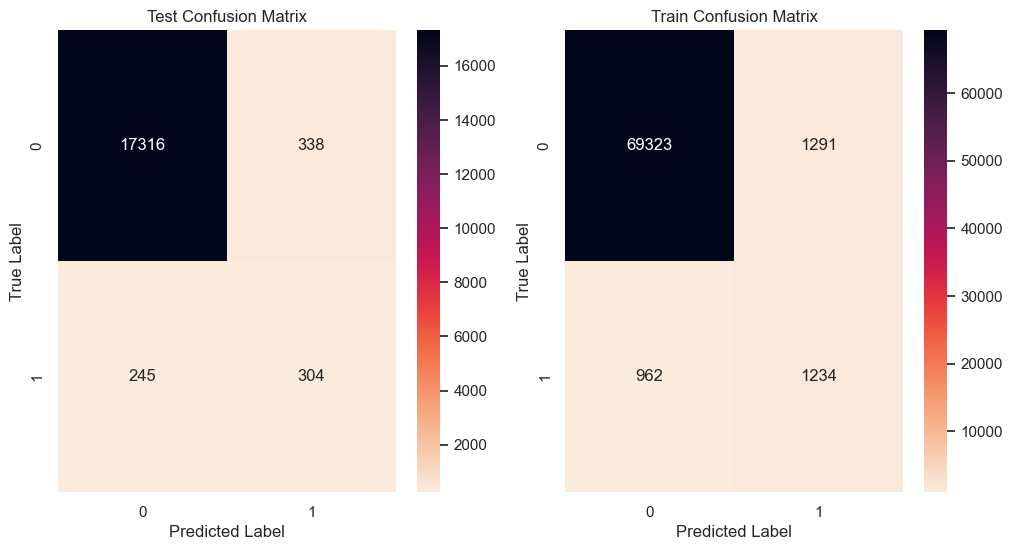

In [73]:
class_eval(repeat_tree1)

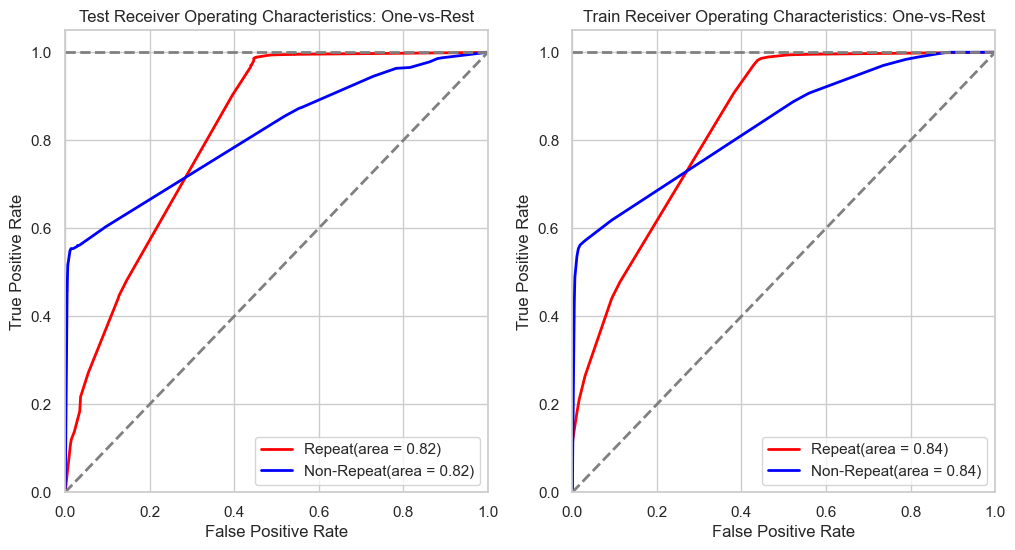

In [74]:
rocauc_eval(repeat_tree1)

# Repeat Buyers Optimization:
optimizing the model using features like gridsearch

c:\Users\cryp1\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters is: {'max_depth': 9, 'max_features': 14, 'min_samples_leaf': 2, 'min_samples_split': 7, 'splitter': 'best'}
Parameters:  {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 9, 'max_features': 14, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 7, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'}

 Test 
------------------------
Accuracy: 0.9929
Precision: 0.9929
Recall: 0.9929
F1 Score: 0.9929
Specificity: 0.9966

 Train 
------------------------
Accuracy: 0.9954
Precision: 0.9953
Recall: 0.9954
F1 Score: 0.9953
Specificity: 0.9979


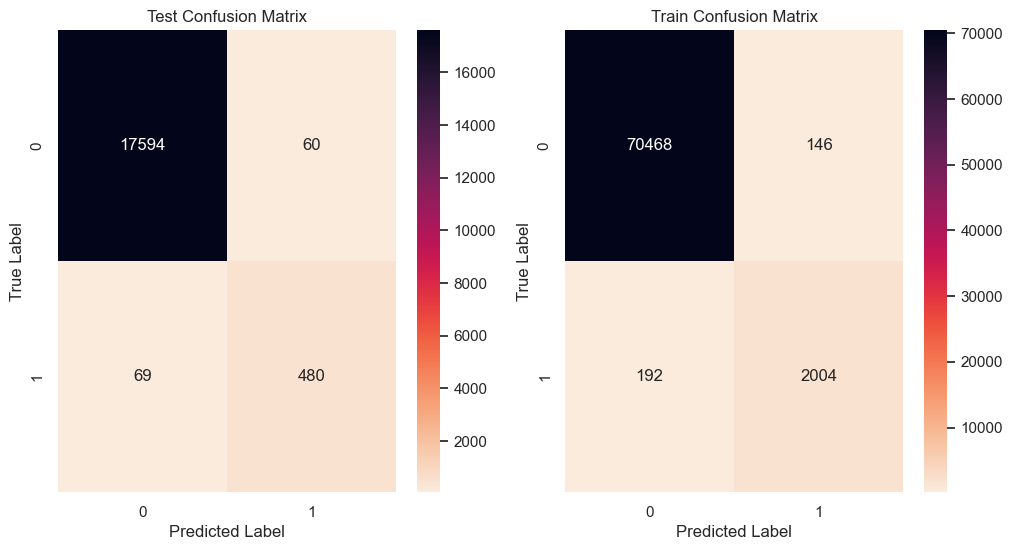

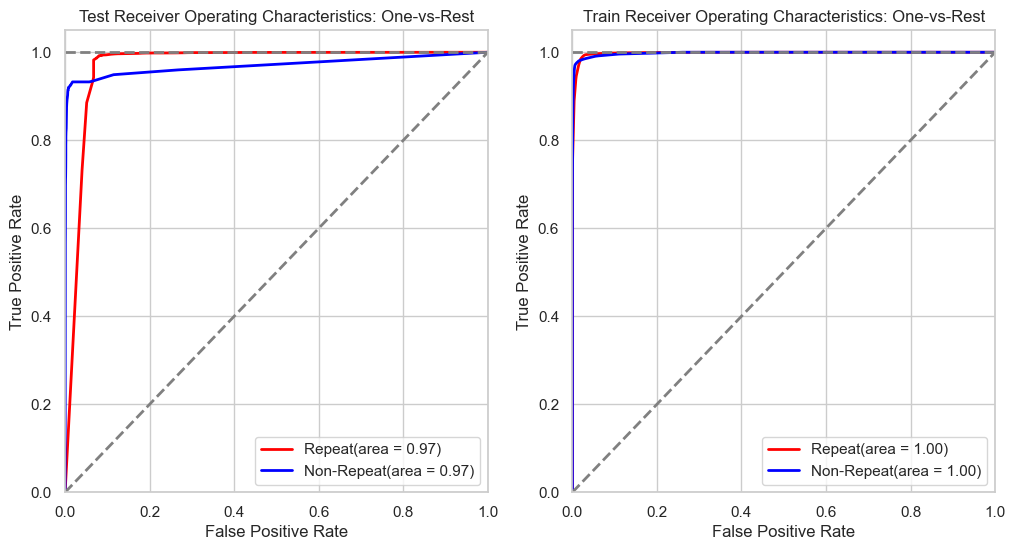

In [75]:
# define search range
param_grid = {'max_depth': list(range(7, 11)), 'splitter': ['best', 'random'],
'max_features': range(12, 15), 'min_samples_leaf': range(1, 4), 'min_samples_split': range(5, 9)}

# repeat buyer:
repeat_treegrid1 = gridcv_tree(param_grid)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
{'n_estimators': 66, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 8, 'max_depth': 6, 'learning_rate': 0.25}

 Test 
------------------------
Accuracy: 0.9939
Precision: 0.9939
Recall: 0.9939
F1 Score: 0.9939
Specificity: 0.9967

 Train 
------------------------
Accuracy: 0.9998
Precision: 0.9998
Recall: 0.9998
F1 Score: 0.9998
Specificity: 0.9998


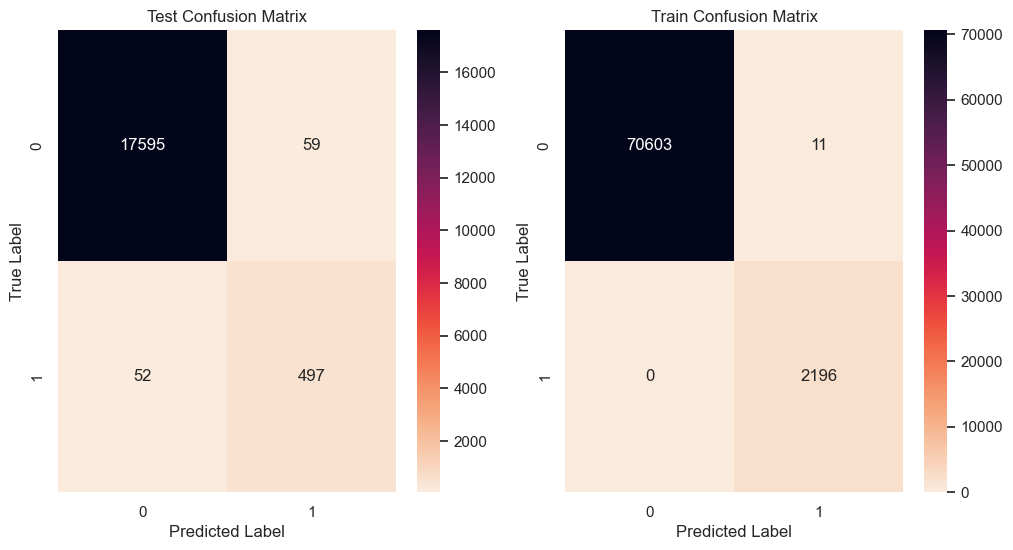

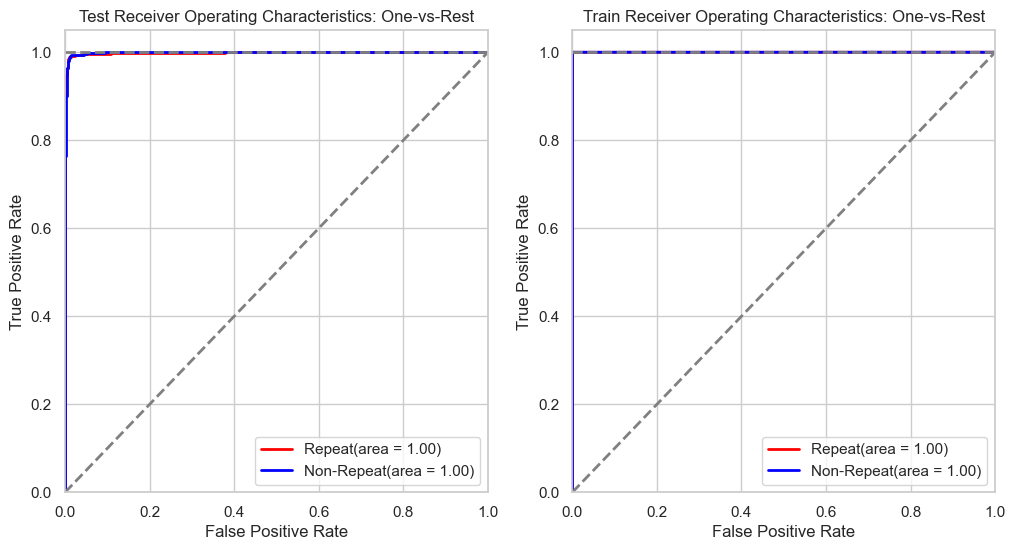

In [76]:
param_dist = {
    "max_depth": range(4, 7),
    "max_features": range(5, len(selected_X)),
    "min_samples_leaf": range(2, 4),
    "min_samples_split": range(2, 4),
    "n_estimators": [56, 66],
    "learning_rate": [0.2, 0.22, 0.25]
}
repeat_gb_class1, repeat_gb_random1 = randomcv_tree(GradientBoostingClassifier(random_state=42), param_dist)
print(repeat_gb_random1.best_params_)
class_eval(repeat_gb_class1)
rocauc_eval(repeat_gb_class1)


 Test 
------------------------
Accuracy: 0.9939
Precision: 0.9939
Recall: 0.9939
F1 Score: 0.9939
Specificity: 0.9967

 Train 
------------------------
Accuracy: 0.9998
Precision: 0.9998
Recall: 0.9998
F1 Score: 0.9998
Specificity: 0.9998


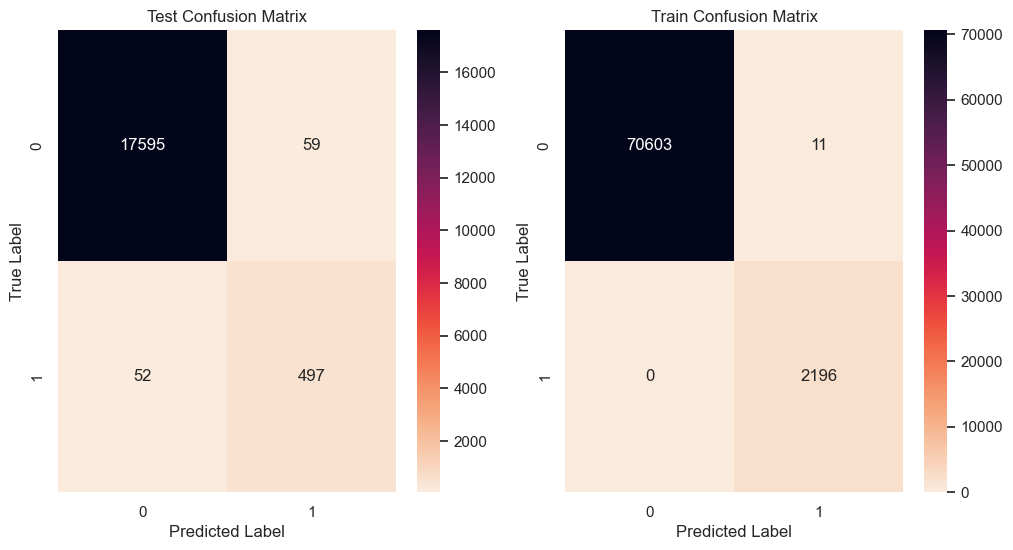

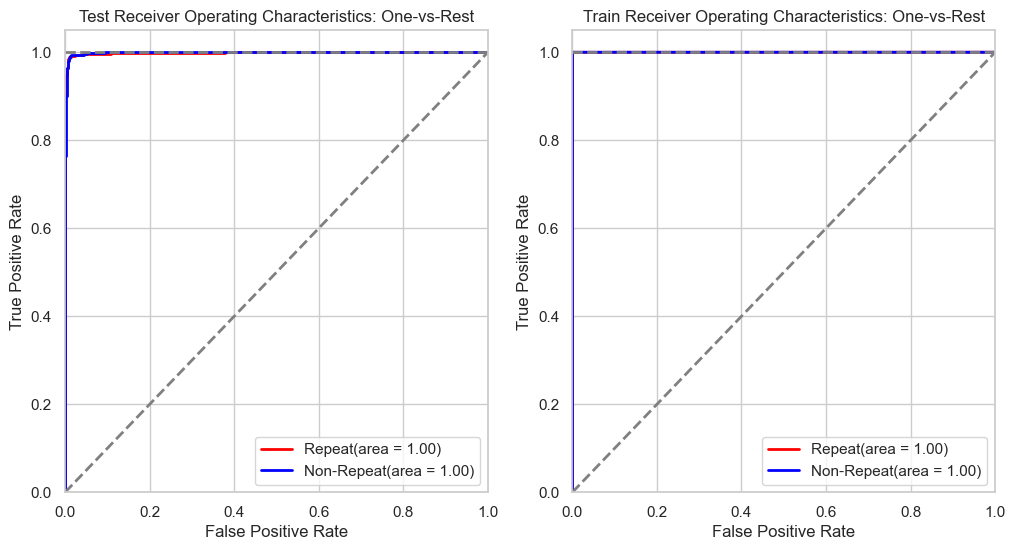

In [77]:
repeat_gb_class2 = GradientBoostingClassifier(n_estimators=66, min_samples_split=3, min_samples_leaf=3, max_features=8, max_depth=6, learning_rate=0.25, random_state=42)
repeat_gb_class2.fit(X_train, y_train)
class_eval(repeat_gb_class2)
rocauc_eval(repeat_gb_class2)

# SKLearn Model for freight value

In [78]:
print(final_df.head().to_string())

                 customer_unique_id weekday_<lambda>  hour_median  price_sum  price_mean  freight_value_mean payment_type_<lambda>  payment_installments_mean  payment_value_sum  payment_value_mean  review_score_mean  product_photos_qty_mean  product_weight_g_mean  product_length_cm_mean  product_height_cm_mean  product_width_cm_mean customer_city_<lambda> customer_state_<lambda>  geolocation_lat_mean  geolocation_lng_mean season_<lambda>  delivery_time_mean product_category_name_english  order_count  repeat_buyer  distinct_product_categories  months_inactive  avg_distance_km  volume_mean  cost_volume  density_mean  cost_weight  lh_ratio  lw_ratio  hw_ratio
0  0000366f3b9a7992bf8c76cfdf3221e2         Thursday         10.0     129.90      129.90               12.00           credit_card                        8.0             141.90              141.90                5.0                      1.0                 1500.0                    34.0                     7.0                   32.0 

In [79]:
print(final_df['freight_value_mean'].describe())

count    91013.000000
mean        20.204764
std         15.740062
min          0.000000
25%         13.370000
50%         16.420000
75%         21.220000
max        409.680000
Name: freight_value_mean, dtype: float64


In [80]:
selected_X = ['hour_median', 'price_mean', 'geolocation_lat_mean', 'avg_distance_km',
              'geolocation_lng_mean', 'product_weight_g_mean', 'product_length_cm_mean',
              'product_height_cm_mean', 'product_width_cm_mean', 'volume_mean', 'delivery_time_mean']
X_train, X_test, y_train, y_test = data_splitter(selected_X, 'freight_value_mean', stratify=False)

In [81]:
freight_linmodel1 = LinearRegression()
freight_linmodel1.fit(X_train, y_train)
print(freight_linmodel1.score(X_test, y_test))

0.6196754582726967



 Test 
---------------------------
MAE: -5.0285
MSE: -89.2655
R^2: 0.6197

 Train 
---------------------------
MAE: -5.1044
MSE: -97.4793
R^2: 0.6116


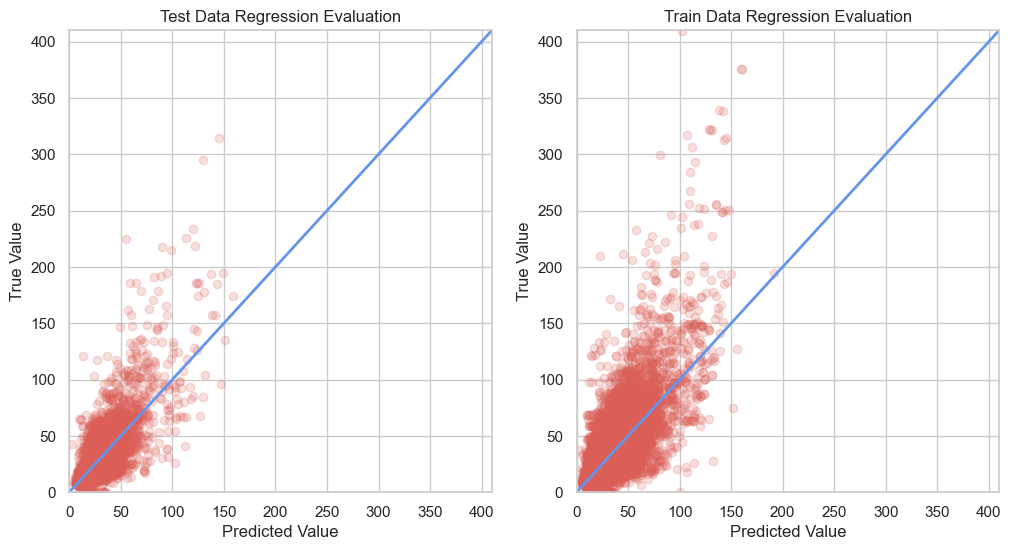

In [82]:
cont_eval(freight_linmodel1, 410, 410)


 Test 
---------------------------
MAE: -5.6070
MSE: -105.9652
R^2: 0.5485

 Train 
---------------------------
MAE: -5.5350
MSE: -96.8412
R^2: 0.6142


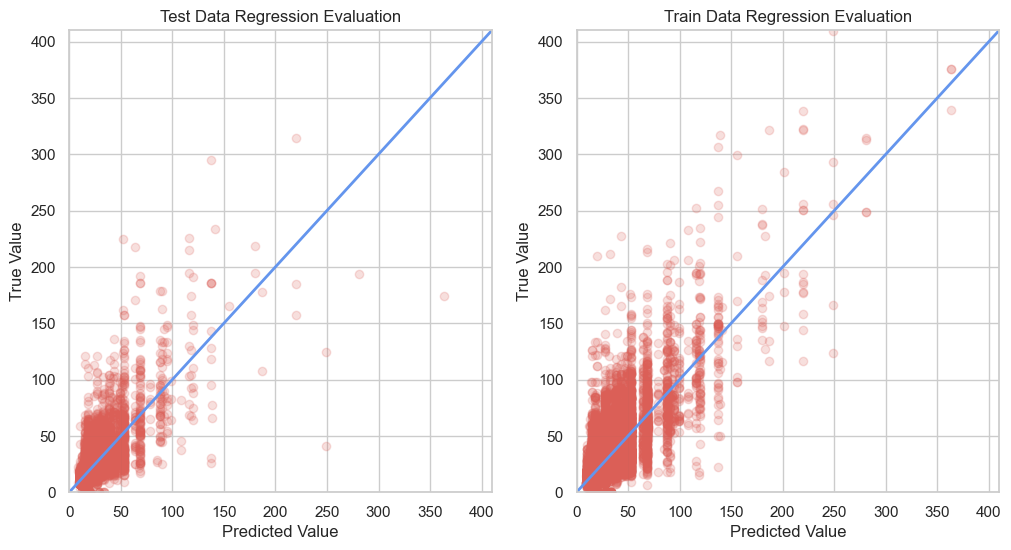

In [83]:
freight_treemodel1 = DecisionTreeRegressor(max_depth=6, max_features=3, min_samples_leaf=3, 
                                          min_samples_split=3, splitter='best', random_state=42)
freight_treemodel1.fit(X_train, y_train)
cont_eval(freight_treemodel1, 410, 410)

# Optimizing the model with various techniques
Utilizing RandomizedSearchCV, ensemble models, feature importance selection

In [84]:
selected_X = ['hour_median', 'price_sum', 'price_mean', 'geolocation_lat_mean',
              'geolocation_lng_mean', 'product_weight_g_mean', 'product_length_cm_mean',
              'product_height_cm_mean', 'product_width_cm_mean', 'volume_mean', 'delivery_time_mean',
              'cost_volume', 'density_mean', 'cost_weight', 'lh_ratio', 'lw_ratio', 'hw_ratio']
X_train, X_test, y_train, y_test = data_splitter(selected_X, 'freight_value_mean', stratify=False,
                                                 cat_process=OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))

In [ ]:
param_dist = {
    "max_depth": range(5, 7),
    "max_features": range(1, 3),
    "min_samples_leaf": range(1, 3),
    "min_samples_split": range(2, 4),
    "n_estimators": [10, 20, 30],
    "learning_rate": [0.05, 0.1, 0.5]
}
# gb: gradientboostregressor
freight_gb_reg1, freight_gb_random1 = randomcv_tree(GradientBoostingRegressor(random_state=42, loss='absolute_error'), param_dist)
print(freight_gb_random1.best_params_)
print("best mae from grid:", freight_gb_random1.best_score_)
cont_eval(freight_gb_reg1, 410, 410)

TypeError: randomcv_tree() got an unexpected keyword argument 'random_state'

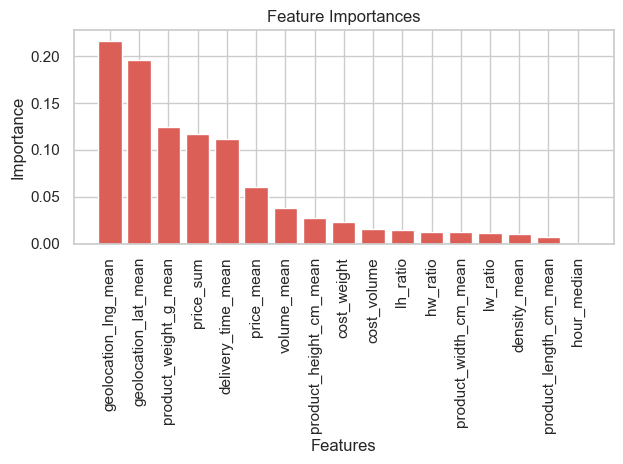

In [ ]:
feature_imp(freight_gb_reg1, selected_X)

In [ ]:
selected_X = [
    'price_mean', 'price_sum', 'geolocation_lat_mean', 'geolocation_lng_mean',
    'product_weight_g_mean', 'volume_mean',
    'weekday_<lambda>', 'season_<lambda>', 'delivery_time_mean'
]
X_train, X_test, y_train, y_test = data_splitter(selected_X, 'freight_value_mean', stratify=False,
                                                  cat_process=OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))

Fitting 3 folds for each of 25 candidates, totalling 75 fits
{'n_estimators': 86, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 7, 'max_depth': 8, 'learning_rate': 0.22}
best mae from grid: -4.209689105805993

 Test 
---------------------------
MAE: -4.0805
MSE: -76.6362
R^2: 0.6735

 Train 
---------------------------
MAE: -3.6017
MSE: -65.5677
R^2: 0.7388


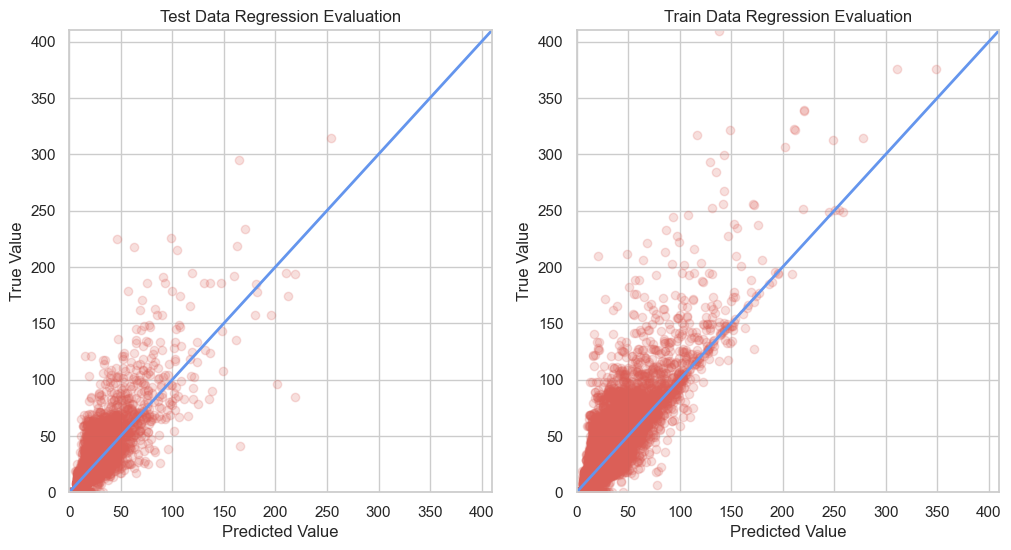

In [ ]:
param_dist = {
    "max_depth": range(5, 9),
    "max_features": range(5, len(selected_X)),
    "min_samples_leaf": range(2, 4),
    "min_samples_split": range(2, 4),
    "n_estimators": [76, 86],
    "learning_rate": [0.2, 0.22, 0.25]
}
freight_gb_reg2, freight_gb_random2 = randomcv_tree(GradientBoostingRegressor(random_state=42, loss='absolute_error'), param_dist)
print(freight_gb_random2.best_params_)
print("best mae from grid:", freight_gb_random2.best_score_)
cont_eval(freight_gb_reg2, 410, 410)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
{'n_estimators': 56, 'learning_rate': 0.05, 'estimator__min_samples_split': 3, 'estimator__min_samples_leaf': 2, 'estimator__max_features': 7, 'estimator__max_depth': 8}
best mae from grid: -5.059817330283886

 Test 
---------------------------
MAE: -5.0333
MSE: -87.8014
R^2: 0.6259

 Train 
---------------------------
MAE: -4.8236
MSE: -66.7343
R^2: 0.7341


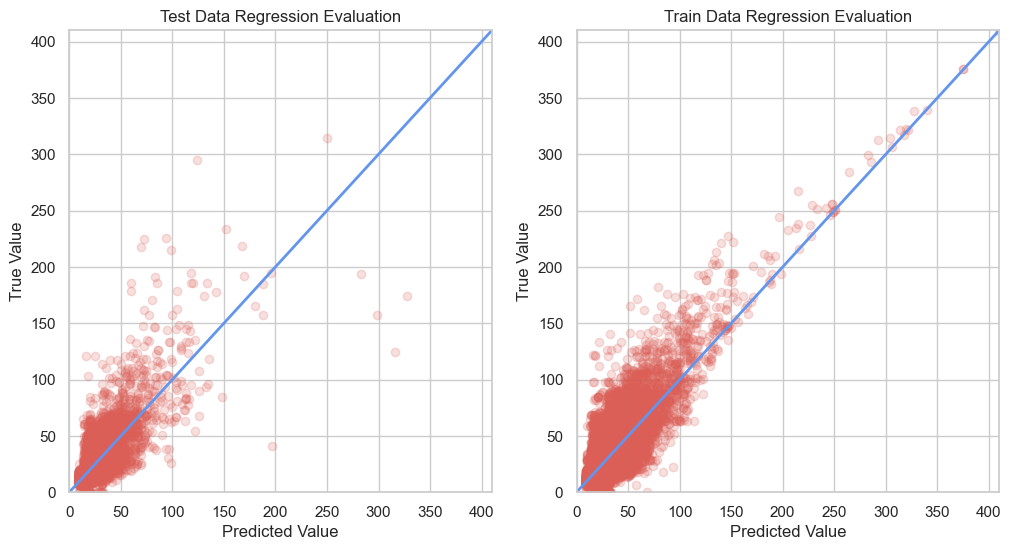

In [ ]:
param_dist = {
    "estimator__max_depth": range(5, 9),
    "estimator__max_features": range(5, len(selected_X)),
    "estimator__min_samples_leaf": range(2, 4),
    "estimator__min_samples_split": range(2, 4),
    "n_estimators": [46, 56, 66],
    "learning_rate": [0.05, 0.1, 0.2]
}
# ada: adaboostregressor
base_estimator = DecisionTreeRegressor(random_state=42)
freight_ada_reg1, freight_ada_random1 = randomcv_tree(AdaBoostRegressor(estimator=base_estimator, random_state=42), param_dist)
print(freight_ada_random1.best_params_)
print("best mae from grid:", freight_ada_random1.best_score_)
cont_eval(freight_ada_reg1, 410, 410)


 Test 
---------------------------
MAE: -4.0805
MSE: -76.6362
R^2: 0.6735

 Train 
---------------------------
MAE: -3.6017
MSE: -65.5677
R^2: 0.7388


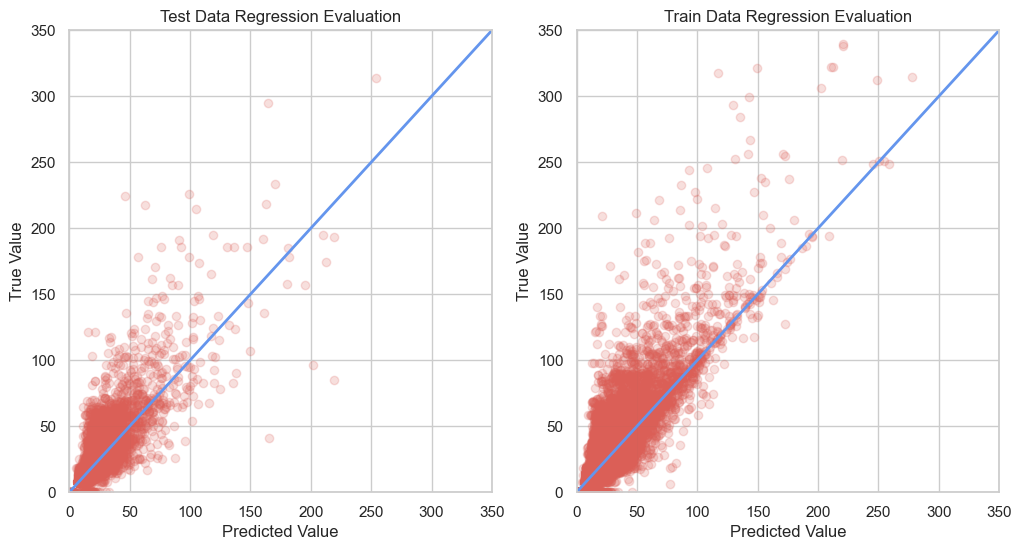

In [ ]:
gb_reg3 = GradientBoostingRegressor(random_state=42, loss='absolute_error', max_depth=8,
                                     max_features=7, min_samples_leaf=3, min_samples_split=2,
                                       n_estimators=86, learning_rate=0.22)
gb_reg3.fit(X_train, y_train)
cont_eval(gb_reg3, 350, 350)

# SKLearn ML model for Delivery Time

In [ ]:
print(final_df.head().to_string())
print(final_df.columns)

                 customer_unique_id weekday_<lambda>  hour_median  price_sum  price_mean  freight_value_mean payment_type_<lambda>  payment_installments_mean  payment_value_sum  payment_value_mean  review_score_mean  product_photos_qty_mean  product_weight_g_mean  product_length_cm_mean  product_height_cm_mean  product_width_cm_mean customer_city_<lambda> customer_state_<lambda>  geolocation_lat_mean  geolocation_lng_mean season_<lambda>  delivery_time_mean product_category_name_english  order_count  repeat_buyer  distinct_product_categories  months_inactive  avg_distance_km  volume_mean  cost_volume  density_mean  cost_weight  lh_ratio  lw_ratio  hw_ratio
0  0000366f3b9a7992bf8c76cfdf3221e2         Thursday         10.0     129.90      129.90               12.00           credit_card                        8.0             141.90              141.90                5.0                      1.0                 1500.0                    34.0                     7.0                   32.0 

count    91013.000000
mean        12.047662
std          9.457407
min          0.000000
25%          6.000000
50%         10.000000
75%         15.000000
max        208.000000
Name: delivery_time_mean, dtype: float64


[]

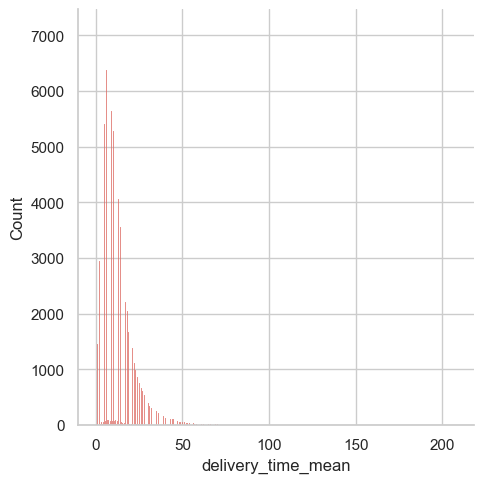

In [ ]:
print(final_df['delivery_time_mean'].describe())
sns.displot(final_df['delivery_time_mean'])
plt.plot()

In [ ]:
selected_X = ['weekday_<lambda>', 'hour_median', 'price_mean', 'freight_value_mean',
              'product_weight_g_mean', 'product_length_cm_mean', 'product_height_cm_mean',
              'product_width_cm_mean', 'customer_city_<lambda>', 'customer_state_<lambda>',
              'geolocation_lat_mean', 'geolocation_lng_mean', 'season_<lambda>', 'avg_distance_km',
              'volume_mean']
X_train, X_test, y_train, y_test = data_splitter(selected_X, 'delivery_time_mean', stratify=False,
                                                  cat_process=OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))


 Test 
---------------------------
MAE: -5.2063
MSE: -67.9033
R^2: 0.2349

 Train 
---------------------------
MAE: -5.1910
MSE: -67.8792
R^2: 0.2425


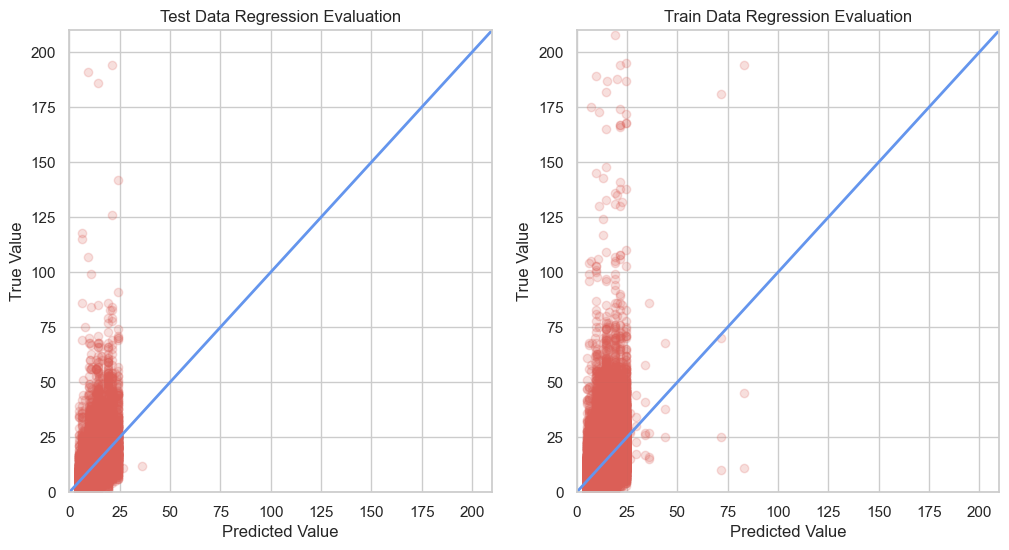

In [ ]:
delivery_treemodel1 = DecisionTreeRegressor(max_depth=6, max_features=3, min_samples_leaf=3, 
                                          min_samples_split=3, splitter='best', random_state=42)
delivery_treemodel1.fit(X_train, y_train)
cont_eval(delivery_treemodel1, 210, 210)

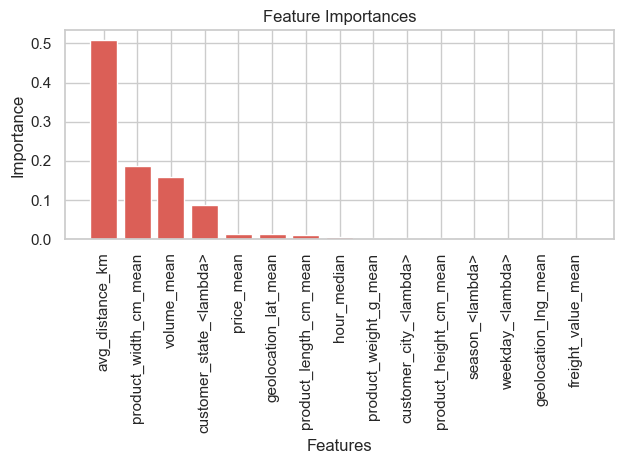

In [ ]:
feature_imp(delivery_treemodel1, selected_X)

In [ ]:
selected_X = ['weekday_<lambda>', 'hour_median', 'price_mean', 'freight_value_mean',
              'product_weight_g_mean', 'customer_city_<lambda>', 'customer_state_<lambda>',
              'geolocation_lat_mean', 'geolocation_lng_mean', 'avg_distance_km']
X_train, X_test, y_train, y_test = data_splitter(selected_X, 'delivery_time_mean', stratify=False,
                                                  cat_process=OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))

Fitting 3 folds for each of 25 candidates, totalling 75 fits
{'n_estimators': 50, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 3, 'max_depth': 5, 'learning_rate': 0.3}
best mae from grid: -4.893386486500151

 Test 
---------------------------
MAE: -4.8699
MSE: -71.6436
R^2: 0.1927

 Train 
---------------------------
MAE: -4.7454
MSE: -70.5480
R^2: 0.2128


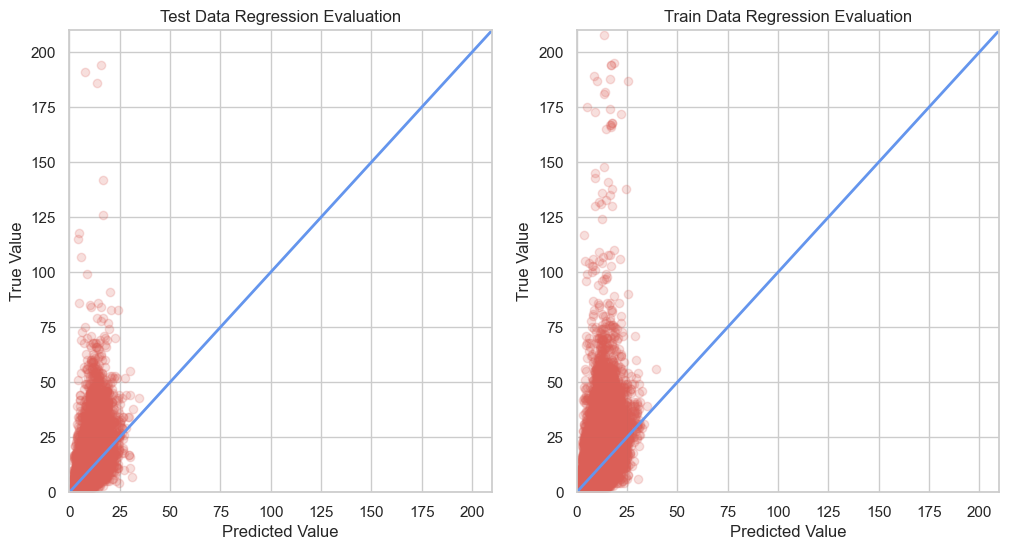

In [ ]:
param_dist = {
    "max_depth": range(4, 7),
    "max_features": range(1, 4),
    "min_samples_leaf": range(1, 3),
    "min_samples_split": range(2, 4),
    "n_estimators": [35, 40, 50],
    "learning_rate": [0.2, 0.3, 0.5]
}

delivery_gb_reg1, delivery_gb_random1 = randomcv_tree(GradientBoostingRegressor(random_state=42, loss='absolute_error'), param_dist)
print(delivery_gb_random1.best_params_)
print("best mae from grid:", delivery_gb_random1.best_score_)
cont_eval(delivery_gb_reg1, 210, 210)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
{'n_estimators': 86, 'learning_rate': 0.05, 'estimator__min_samples_split': 2, 'estimator__min_samples_leaf': 2, 'estimator__max_features': 9, 'estimator__max_depth': 8}
best mae from grid: -5.55779769538643

 Test 
---------------------------
MAE: -5.5945
MSE: -70.5626
R^2: 0.2049

 Train 
---------------------------
MAE: -5.5037
MSE: -60.5077
R^2: 0.3248


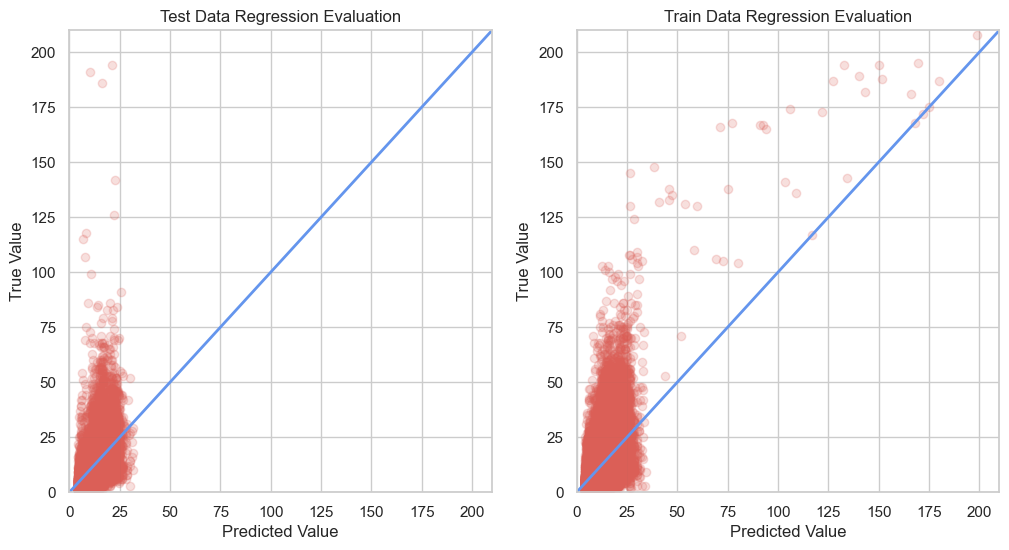

In [ ]:
param_dist = {
    "estimator__max_depth": range(5, 9),
    "estimator__max_features": range(5, len(selected_X)),
    "estimator__min_samples_leaf": range(2, 4),
    "estimator__min_samples_split": range(2, 4),
    "n_estimators": [66, 76, 86],
    "learning_rate": [0.05, 0.1, 0.2]
}
# ada: adaboostregressor
base_estimator = DecisionTreeRegressor(random_state=42)
delivery_ada_reg1, delivery_ada_random1 = randomcv_tree(AdaBoostRegressor(estimator=base_estimator, random_state=42), param_dist)
print(delivery_ada_random1.best_params_)
print("best mae from grid:", delivery_ada_random1.best_score_)
cont_eval(delivery_ada_reg1, 210, 210)


 Test 
---------------------------
MAE: -4.8699
MSE: -71.6436
R^2: 0.1927

 Train 
---------------------------
MAE: -4.7454
MSE: -70.5480
R^2: 0.2128


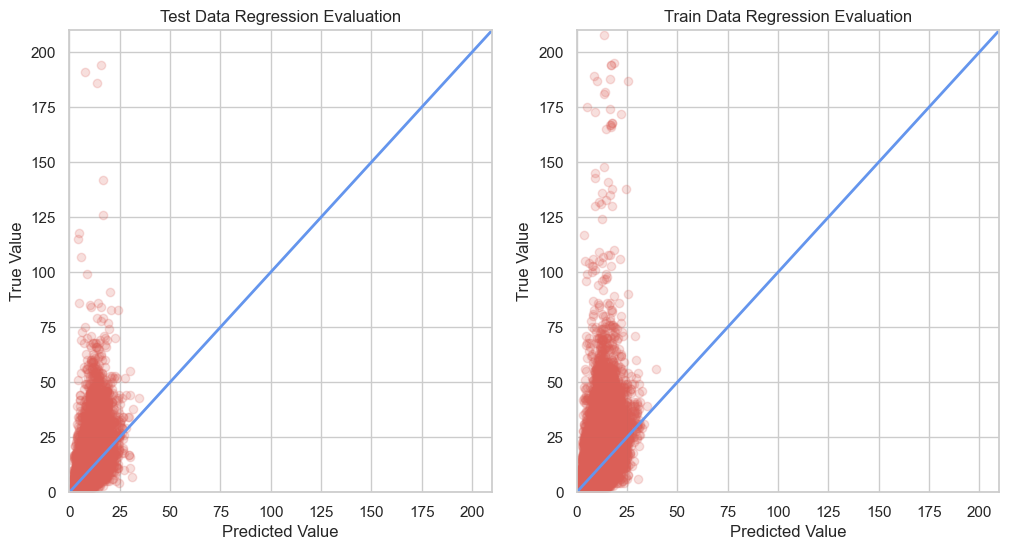

In [ ]:
delivery_gb_reg2 = GradientBoostingRegressor(n_estimators=50, min_samples_split=3, min_samples_leaf=2,
                                            max_features=3, max_depth=5, learning_rate=0.3,
                                            random_state=42, loss='absolute_error')
delivery_gb_reg2.fit(X_train, y_train)
cont_eval(delivery_gb_reg2, 210, 210)

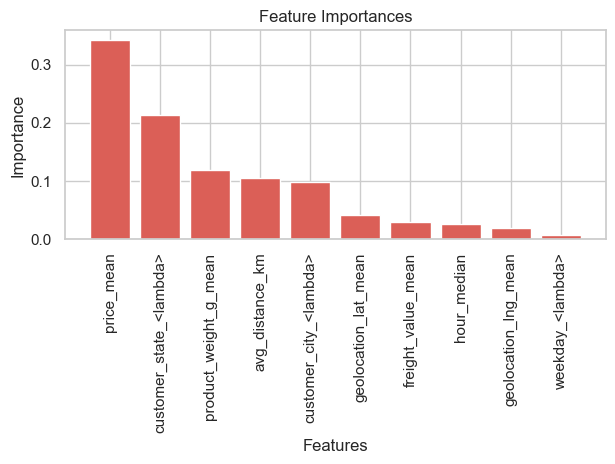

In [ ]:
feature_imp(delivery_gb_reg2, selected_X)

# ML Modelling Conclusions
Repeat Buyers Model:
Training was relatively easy for the repeat buyers column, achieving an incredibly high training and testing accuracy. However, the 100% accuracies may be due to the small size of the data. 

Freight Value Model:
Training was significantly difficult for freight value mean column compared to the repeat buyers column. It required the utilization of various different techniques like grid search, randomized search, feature importance, careful and logical feature selection and multiple iterations that are not present within this file to maintain it's small size.

Delivery Time Model:
Training was not as difficult for delivery time mean column compared to the freight value mean column. Many of the existing techniques present for the freight value model could be easily carried forward for delivery time modelling. However, fine tuning and getting the model to achieve any significant accuracy over predicting the mean delivery value was difficult.